**Introduction**: In this approach, we will implement an unsupervised learning strategy to differentiate between GenAI-generated and real images. Unlike supervised models that rely on labeled data, our method will leverage clustering and similarity measures to group similar images without predefined labels.We will be performing below things
1. Cosine Similarity Matrix Clustering
We compute the cosine similarity between image embeddings, to understand the similarity between images.

2. Unsupervised Clustering Algorithm
We will be applying an unsupervised clustering technique, such as K-Means or LHS, to group images with similar embeddings, helping to distinguish patterns in the dataset.
and perform visualization by  t-Distributed Stochastic Neighbor Embedding (t-SNE).
This approach allows us to uncover hidden patterns in the dataset, aiding in the differentiation of GenAI and real images without requiring labeled data.



Mount the Google Drive in a Google Colab environment



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

#Read the embeddings dataframe

In [4]:
import pandas as pd
import numpy as np
import torch

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])


df = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
del df['Unnamed: 0']
df['embeddings'] = df['embeddings'].apply(string_to_float_array)
df.head()

,embeddings,image_name,label
0,"[0.12522172927856445, 0.17127607762813568, -0....",354503ce71788b2f7725480f7a96123c,0
1,"[0.00956397969275713, -0.024535341188311577, -...",d59817583d8f5081d293afe840ea3da4,1
2,"[-0.014325050637125969, 0.026381907984614372, ...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[-0.09597162157297134, 0.10650302469730377, -0...",00becac4c25ad5a0c839e1629bedb899,1
4,"[0.368219792842865, 0.17371228337287903, -0.01...",0a5bae79ca67e303fe64e0db70565ed1,1


#2D and 3D t-SNE for Visualization for our embeddings
Below we will perform t-SNE directly to embeddings to reduce dimensions from 512 to 2. We will be using labels only for color coding. In this no clustering will be performed. Only T-SNE transformation and label based visualization. This will signify how well the embedidngs naturally seperate in the dataset.
Overall, t-SNE is more effective for capturing complex relationships and local structures in high-dimensional data

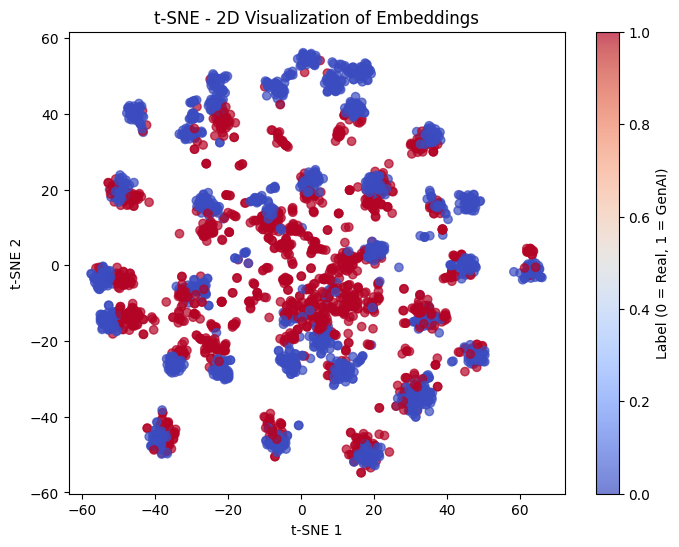

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeddings=np.vstack(df['embeddings'].values)
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Add t-SNE results to dataframe
df['tsne_1'] = tsne_result[:, 0]
df['tsne_2'] = tsne_result[:, 1]

# Plot in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df['tsne_1'], df['tsne_2'], c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Label (0 = Real, 1 = GenAI)')
plt.title('t-SNE - 2D Visualization of Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Summary from above graph

The clusters indicate that the embeddings contain some identifiable differences between real and AI-generated images.
Clusters at the edges of the plot suggest that certain real or GenAI images are more distinctly different.
Overlapping areas (blue and red dots mixed) suggest that some AI-generated images resemble real ones.
This shows that certain AI-generated images might be harder to distinguish from real ones.
Good separation of clusters, Embeddings are informative for classification.
High overlap, More complex patterns requiring deeper feature extraction or more sophisticated models.

t-SNE for 3D visualization

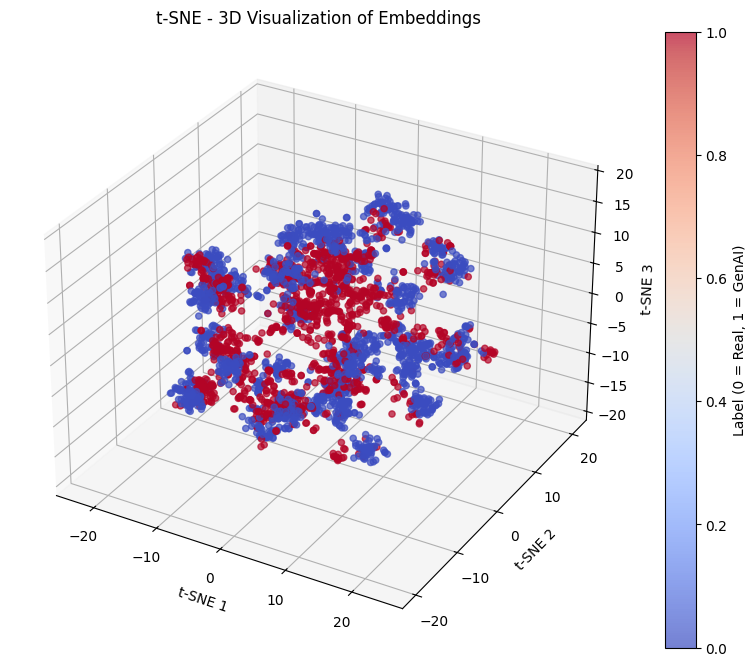

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(sc, label='Label (0 = Real, 1 = GenAI)')
ax.set_title('t-SNE - 3D Visualization of Embeddings')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

Summary from the above graph

We can observe less overlapping, good seperated and distinct clusters. This suggests that Classification Models would work for training.

#K-Means clustering and apply t-SNE for Visualization

Below we will perform the K-Means Clustering and compute the Adjusted Rand Index (ARI) to measure how well K-Means aligns with true labels. After that we can visualize the results iusing t-SNE. Here instead of labels we will be using L-Means cluster assignments. This will help to understand how well K-Means groups images rather than there natural seperation as previously done.

Adjusted Rand Index (ARI) Score: 0.0132


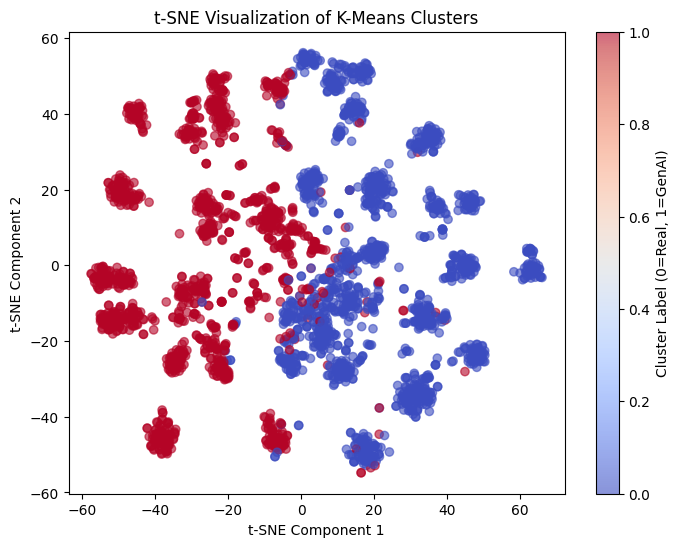

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

#Convert embeddings from list format to NumPy array
embeddings = np.stack(df['embeddings'].values)

# Extract labels
labels = df['label'].values

# Apply K-Means Clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Compute Adjusted Rand Index (to evaluate clustering)
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plot t-SNE visualization of clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster Label (0=Real, 1=GenAI)")
plt.show()



The ARI score of 0.0132 suggests that clustering not that great but better than random


Looks like there might be subclusters. Lets analyze by increasing K if it impacts ARI score.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

#Convert embeddings from list format to NumPy array
embeddings = np.stack(df['embeddings'].values)

# Extract labels
labels = df['label'].values

# Apply K-Means Clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Compute Adjusted Rand Index (to evaluate clustering)
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")

Adjusted Rand Index (ARI) Score: 0.0516


I analyzed multiple values for
K= 4  ARI=0.0516,
K=7   ARI=0.0353,
K=10  ARI=0.0332.

#Confusion Matrix for K-Means

In [12]:
from sklearn.metrics import confusion_matrix

#Find the assigned cluster for each datapoint
cluster_assignments = kmeans.labels_  # Shape: (N,)
print(cluster_assignments[:10])  # First 10 assignments

#Lets compare true labels with the K-Means cluster assignments.
conf_matrix = confusion_matrix(labels, cluster_assignments)
print(conf_matrix)  # 2x2 matrix for K=2


[0 0 0 0 0 0 0 0 0 1]
[[1019  729]
 [ 636  706]]


From the above confusion Matrix, 1019 True images are correct, 729 were misclassified.
639 GenAI images were misclassified, 706 Gen AI images were correctly classified.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

centroid_matrix = kmeans.cluster_centers_  # Shape: (K, D)
print(centroid_matrix.shape)  # (2, 512) if K=2 and embeddings are 512-dimensional


similarity_matrix = cosine_similarity(centroid_matrix)
print(similarity_matrix)  # Shape: (K, K)

(2, 512)
[[1.         0.88134519]
 [0.88134519 1.        ]]


Since the cosine similarity between 2 clusters is 0.88 they are not very distinct. The more cosine value closer to 0 more distinct clusters they are.

How can we improve on the K-Means clustering
1. We can normalize the embeddings before clustering.
2. We can also use ELBOW method to find the optimal K.

Overall it appears we will have to be deeper models.

# Cosine similarity for embeddings

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert embeddings to a numpy array
embeddings = np.array(df['embeddings'].to_list())

# Compute pairwise cosine similarity in one step
cosine_sim_matrix = cosine_similarity(embeddings)

# Print similarity values (if needed)
print(cosine_sim_matrix)


[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


# t-SNE using cosine similarity

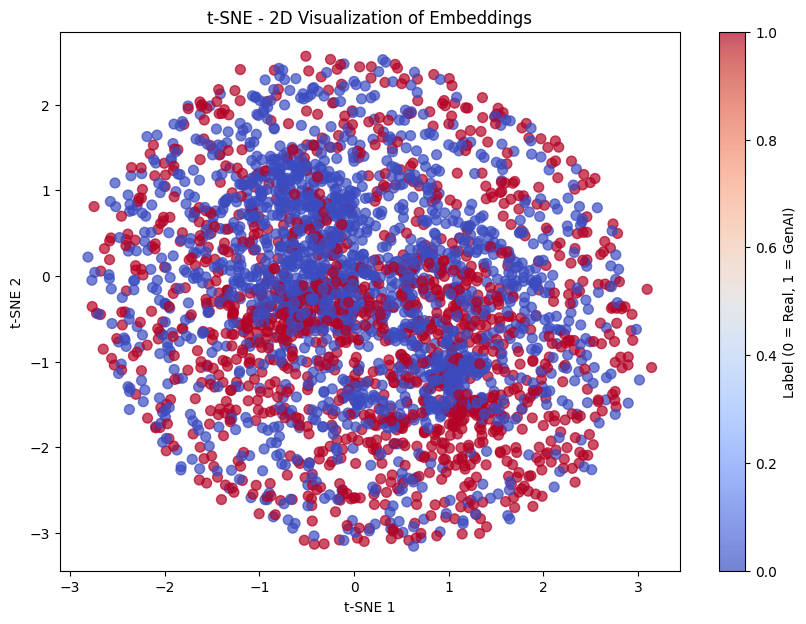

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, init="random", metric="precomputed", random_state=42)
tsne_results = tsne.fit_transform(cosine_sim_matrix)

# Step 3: Plot the t-SNE scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df['label'], cmap='coolwarm', s=50, alpha=0.7)

# Step 4: Add color bar using the scatter object
plt.colorbar(scatter, label='Label (0 = Real, 1 = GenAI)')

plt.title('t-SNE - 2D Visualization of Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Cosine similarity for Normalized embeddings

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def normalize_vector(emb):
  pt_embedding = torch.tensor(emb)
  # Calculate the L2 norm
  norm = torch.norm(pt_embedding, p=2)
  # Normalize the embedding
  normalized_embedding = pt_embedding / norm
  return normalized_embedding
# Create new column for normalized embeddings.
normalized_embeddings = []
for embedding in df['embeddings']:
  normalized_embeddings.append(normalize_vector(embedding))
# Compute pairwise cosine similarity in one step
normalized_cosine_sim_matrix = cosine_similarity(normalized_embeddings)

# Print similarity values (if needed)
print(normalized_cosine_sim_matrix)

[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


In [31]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Convert list of embeddings to NumPy array
embeddings_array = np.vstack(df['embeddings'].values)  # Shape: (N, 512)

# Compute L2 norm and normalize
norms = np.linalg.norm(embeddings_array, axis=1, keepdims=True)  # Compute L2 norms
normalized_embeddings = embeddings_array / norms  # Normalize

# Compute pairwise cosine similarity
normalized_cosine_sim_matrix = cosine_similarity(normalized_embeddings)

print(normalized_cosine_sim_matrix)

[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


# Convert labels and features to train test set

In [62]:
from sklearn.model_selection import train_test_split
import numpy as np

#total_repeatation = 1000 #kept this repetition process optional if we had lesser data

#Remove unnecessary column with regards to training Model
'''if 'image_name' in df.columns:
  df.drop ('image_name', axis=1, inplace=True)
'''
#Separate the features and labels
X = df#.drop('label', axis=1)
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Convert Training Features to NumPy and Torch Tensor
# X_train = pd.concat([X_train] * total_repeatation, ignore_index=True)
X_train_image_names = X_train['image_name']
X_train = np.array(X_train['embeddings'].to_list(), dtype=np.float32)
X_train = torch.from_numpy(X_train)

#Convert Testing Features to NumPy and Torch Tensor
# X_test = pd.concat([X_test] * total_repeatation, ignore_index=True)
X_test = np.array(X_test['embeddings'].to_list(), dtype=np.float32)
X_test = torch.from_numpy(X_test)

#Convert Training Labels to Tensor
# y_train = np.tile(y_train, total_repeatation) # Repeat same data n time
y_train = np.array(y_train.to_list(), dtype=np.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

# Convert Testing Labels to Tensor
# y_test = np.tile(y_test, total_repeatation) # Repeat same data n times
y_test = np.array(y_test.to_list(), dtype=np.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

len(X_train), len(X_test), len(y_train), len(y_test)

(2472, 618, 2472, 618)

#Clustering with Kmeans

We will use Clustering algorithms to find if Real and GenAI images form clusters

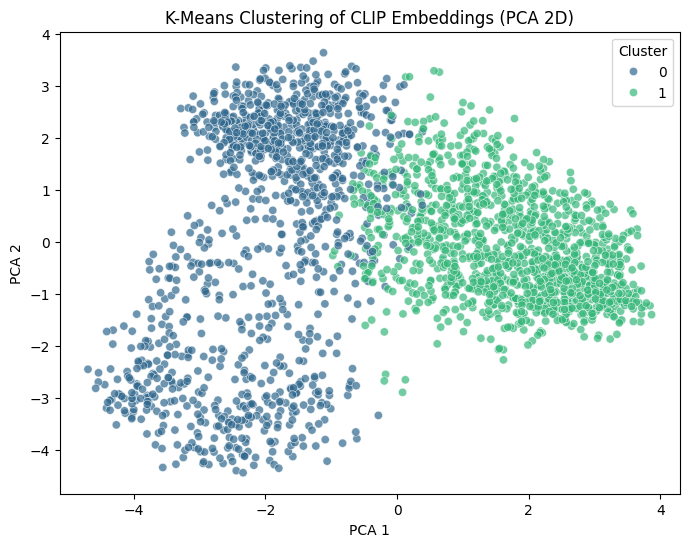

In [56]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

cluster_size = 2
# Run KMeans with 2 clusters (real vs AI-generated)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
clusters = kmeans.fit_predict(X_train)

# Plot clusters using PCA for 2D visualization
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Create DataFrame for plotting
plot_df = pd.DataFrame(X_train_pca, columns=['PCA 1', 'PCA 2'])
plot_df['Cluster'] = clusters
plot_df['Label'] = y_train

# Plot K-Means Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA 1', y='PCA 2',
    hue='Cluster', palette='viridis',
    data=plot_df, alpha=0.7
)
plt.title('K-Means Clustering of CLIP Embeddings (PCA 2D)')
plt.show()

Summary from the above K-Means clustering using PCA approach
1. The data is visually divided in two groups.
2. The K-Means Algorithm found two natural clusters in PCA reduced embedding space.
3. PCA Reduction: The data has been transformed into two dimensions (PCA 1 and PCA 2), allowing us to visualize complex, high-dimensional CLIP embeddings in 2D.

Confusion Matrix:
                  Predicted 0  Predicted 1
Actual 0 (Real)           812          588
Actual 1 (GenAI)          505          567


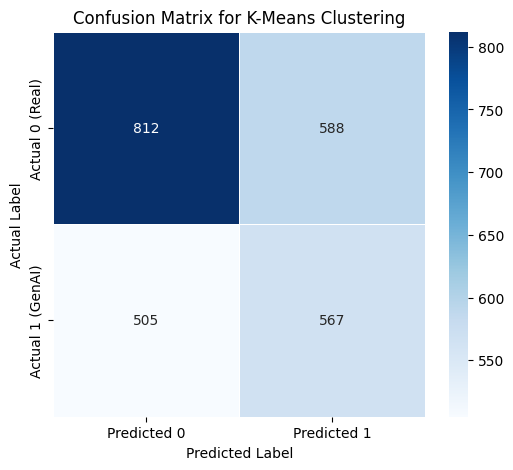

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

np.random.seed(42)

# Run K-Means Clustering
cluster_size = 2
kmeans = KMeans(n_clusters=cluster_size, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_train, clusters)

# Convert to DataFrame for better visualization
df_conf_matrix = pd.DataFrame(conf_matrix,
                              index=['Actual 0 (Real)', 'Actual 1 (GenAI)'],
                              columns=['Predicted 0', 'Predicted 1'])

# Print Confusion Matrix
print("Confusion Matrix:")
print(df_conf_matrix)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()


About 812 real images were correctly classified and 588 real images were incorrectly classified.
About 567 Gen AI were correctly classified vs 505 Gen AI were incorrectly classified.

Summary
From the above K-Means Algorithm and Cosine Similarity Analysis, it looks like unsupervised Model does not work well for our dataset.